In [2]:

import pandas as pd
import nltk
import string
from gensim.models import Word2Vec
import shutil
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import shap


In [3]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [4]:
review_df = pd.read_csv("../dataset/embled_review_combined.csv", encoding='utf-8')

In [5]:
review_df

,rating,location_id,review,cleaned_review,embedding,sentiment
0,3,4322585,This was an ornate wat inside Mae Sot. It is a...,ornate wat inside mae sot burmese style wat ty...,[[ 0. 0. 0. ... 0. ...,neutral
1,2,2667297,Got the Asia perfect for body treatment. We re...,got asia perfect body treatment read review th...,[[ 0.00053091 0.15045358 0.00889446 ... -0.0...,negative
2,4,10388576,A few years ago a huge market was built in Ban...,year ago huge market built ban phe totally dis...,[[ 0. 0. 0. ... 0. ...,positive
3,1,6885224,The visit to this island is worth it just to u...,visit island worth understand tragic result un...,[[ 0. 0. 0. ... 0. ...,negative
4,5,6669325,So many different bananas! And a chance to see...,many different banana chance see stored taste ...,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,positive
...,...,...,...,...,...,...
14062,3,7287889,It is not as pretty as some picture lead to be...,pretty picture lead believe big either minute ...,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,neutral
14063,1,10631803,The whole trip was spoilt by lying local tour ...,whole trip spoilt lying local tour package sel...,[[ 0. 0. 0. ... 0. ...,negative
14064,3,1368429,"As a keen biker, I was excited to experience t...",keen biker excited experience breathtaking sce...,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,neutral
14065,5,8300428,This place is really beautiful and was decorat...,place really beautiful decorated statue mae na...,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,positive


In [6]:

vector_size = 300
sentences = [row.split() for row in review_df['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300



In [7]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_len = 100  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

# Create the embedding matrix from the Word2Vec model
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [8]:
def text_to_word2vec(tokens, model, max_length=300):
    vector = np.zeros((max_length, 300))
    for i, word in enumerate(tokens):
        if i < max_length:
            if word in model.wv:
                vector[i] = model.wv[word]
    return vector

review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


In [9]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating in [3, 4]:
        return 'neutral'
    else:  # 4 or 5
        return 'positive'

review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)

In [10]:

# 5. Check the distribution of the classes
print(review_df['sentiment'].value_counts())


sentiment
neutral     6507
negative    4689
positive    2871
Name: count, dtype: int64


In [11]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(review_df['cleaned_review'])

X = tokenizer.texts_to_sequences(review_df['cleaned_review'])
X = pad_sequences(X, maxlen=max_len)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = review_df['sentiment'].map(label_mapping)

In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.3, random_state=42)

In [13]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")


X_train shape: (13664, 100)
y_train shape: (13664,)
X_test shape: (5857, 100)
y_test shape: (5857,)


In [14]:
def get_avg_word2vec(text, model, vector_size):
    avg_vec = np.zeros((vector_size,))
    count = 0
    for word in text:
        if word in model.wv:
            avg_vec += model.wv[word]
            count += 1
    if count > 0:
        avg_vec /= count
    return avg_vec

In [15]:
X_train_w2v = np.array([get_avg_word2vec(sentence, word2vec_model, vector_size) for sentence in X_train_resampled])
X_val_w2v = np.array([get_avg_word2vec(sentence, word2vec_model, vector_size) for sentence in X_val])

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# สร้างและฝึก Decision Tree model
dt_model = DecisionTreeClassifier()
history = dt_model.fit(X_train_w2v, y_train_resampled)

In [17]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [18]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train_resampled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

In [19]:
class_weights_dict = dict(enumerate(class_weights))

In [20]:
class_weights_dict

{0: 1.0132740081572118, 1: 0.9986114156252284, 2: 0.9884259259259259}

### Decision Tree

In [21]:
y_pred_dt = dt_model.predict(X_val_w2v)

# ประเมินผลลัพธ์
print(classification_report(y_val, y_pred_dt))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2012
           1       0.75      0.81      0.78      1946
           2       0.78      0.66      0.71      1899

    accuracy                           0.82      5857
   macro avg       0.82      0.82      0.82      5857
weighted avg       0.82      0.82      0.82      5857



In [22]:
accuracy = accuracy_score(y_val, y_pred_dt)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8236298446303568


Cross-validation scores: [0.81375778 0.79948774 0.79765825 0.79985364 0.80783309]
Mean accuracy: 0.803718099750407


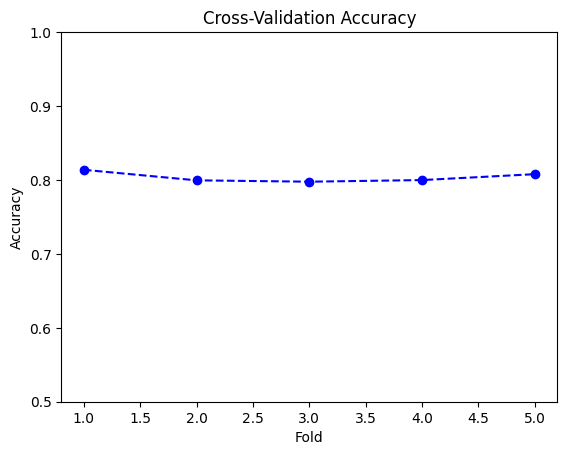

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

cv_scores = cross_val_score(dt_model, X_train_w2v, y_train_resampled, cv=5, scoring='accuracy')

# แสดงค่าความแม่นยำในแต่ละ fold
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

# สร้างกราฟแสดงความแม่นยำในแต่ละ fold
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--', color='b')
plt.title('Cross-Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])  # ตั้งค่าให้แกน Y มีช่วง 0.5 ถึง 1 เพื่อให้เห็นชัดเจน
plt.show()

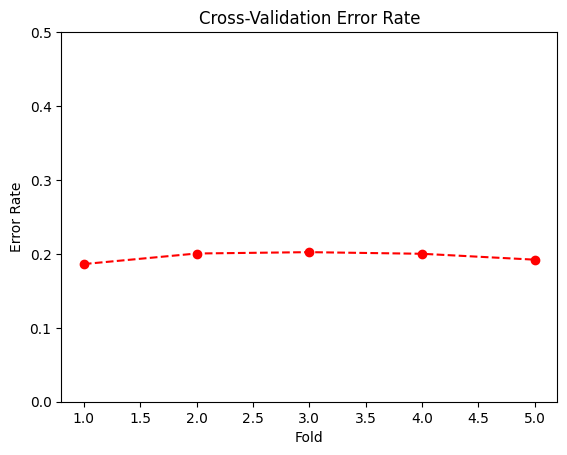

In [24]:
error_rate = 1 - cv_scores

# สร้างกราฟแสดง error rate
plt.plot(range(1, len(error_rate) + 1), error_rate, marker='o', linestyle='--', color='r')
plt.title('Cross-Validation Error Rate')
plt.xlabel('Fold')
plt.ylabel('Error Rate')
plt.ylim([0, 0.5])
plt.show()

In [25]:
review_df.head(5)

,rating,location_id,review,cleaned_review,embedding,sentiment
0,3,4322585,This was an ornate wat inside Mae Sot. It is a...,ornate wat inside mae sot burmese style wat ty...,"[[0.030460486188530922, 0.021254735067486763, ...",neutral
1,2,2667297,Got the Asia perfect for body treatment. We re...,got asia perfect body treatment read review th...,"[[-0.022843047976493835, 0.18187645077705383, ...",negative
2,4,10388576,A few years ago a huge market was built in Ban...,year ago huge market built ban phe totally dis...,"[[-0.005868636071681976, 0.00839421059936285, ...",neutral
3,1,6885224,The visit to this island is worth it just to u...,visit island worth understand tragic result un...,"[[-0.07705406844615936, 0.21747809648513794, 0...",negative
4,5,6669325,So many different bananas! And a chance to see...,many different banana chance see stored taste ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# แปลง label เป็นตัวเลข
label_encoder = LabelEncoder()
review_df['sentiment_label'] = label_encoder.fit_transform(review_df['sentiment'])

# แบ่งข้อมูล train/test
X_train, X_test, y_train, y_val = train_test_split(review_df['cleaned_review'], review_df['sentiment_label'], test_size=0.3, random_state=42)

# สร้าง TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # กำหนดจำนวนฟีเจอร์ที่เราต้องการ

# แปลงข้อมูลข้อความเป็น TF-IDF
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### K-Nearest-Neighbors

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# สร้างโมเดล KNN (กำหนดค่า k เท่ากับ 5)
knn_model = KNeighborsClassifier(
    n_neighbors=3,            # Use 3 neighbors for a balance between sensitivity and stability.
    weights='distance',       # Weight neighbors by distance for better relevance.
    algorithm='auto',         # Let scikit-learn choose the best algorithm based on data.
    leaf_size=30,             # Default value, fine for most use cases.
    p=2,                      # Default for Minkowski (Euclidean), but normalize TF-IDF vectors for cosine similarity.
    metric='minkowski',       # Use with normalization to approximate cosine distance.
    n_jobs=-1                 # Use all cores for faster processing.
)

# ฝึกโมเดล KNN ด้วยข้อมูลฝึก
knn_model.fit(X_train_tfidf, y_train)

# ทำนายผลลัพธ์บนชุดข้อมูล validation
y_pred_knn = knn_model.predict(X_test_tfidf)

# ประเมินความแม่นยำ
accuracy = accuracy_score(y_val, y_pred_knn)
print(f"Accuracy: {accuracy}")

# แสดงรายงานการจัดหมวดหมู่ (classification report)
print(classification_report(y_val, y_pred_knn))


Accuracy: 0.8488509831793414
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1453
           1       0.84      0.86      0.85      1938
           2       0.69      0.55      0.61       830

    accuracy                           0.85      4221
   macro avg       0.82      0.80      0.81      4221
weighted avg       0.84      0.85      0.84      4221



In [28]:
X_train_w2v

array([[ 0.21044314,  0.6480582 , -0.00095526, ..., -0.3081931 ,
         0.50239936, -0.39311127],
       [ 0.22430699,  0.73284416, -0.03330301, ..., -0.33821981,
         0.58953877, -0.40554565],
       [ 0.23464705,  0.73602722, -0.03517248, ..., -0.36583256,
         0.6389647 , -0.43559187],
       ...,
       [ 0.19846293,  0.69614553, -0.00664298, ..., -0.36019123,
         0.64701177, -0.38223458],
       [ 0.15186837,  0.59305907, -0.00645306, ..., -0.29263839,
         0.5338184 , -0.34657374],
       [ 0.20471999,  0.74354665, -0.03360347, ..., -0.35440532,
         0.59718787, -0.43168136]])

In [29]:
y_train_resampled

14420    0
5400     1
214      0
12281    1
11217    0
        ..
11284    2
11964    1
5390     0
860      2
15795    0
Name: sentiment, Length: 13664, dtype: int64

### Naive Bayes

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# สร้างโมเดล Multinomial Naive Bayes
nb_model = MultinomialNB()

# ฝึกโมเดลด้วยข้อมูล TF-IDF ที่แปลงแล้ว
nb_model.fit(X_train_tfidf, y_train)

# ทำนายผลลัพธ์บนชุดข้อมูลทดสอบ
y_pred = nb_model.predict(X_test_tfidf)

# ประเมินความแม่นยำ
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

# แสดงรายงานการจัดหมวดหมู่
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


Accuracy: 0.777303956408434
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1453
           1       0.69      0.96      0.81      1938
           2       0.84      0.23      0.36       830

    accuracy                           0.78      4221
   macro avg       0.82      0.68      0.68      4221
weighted avg       0.81      0.78      0.75      4221

[[1237  213    3]
 [  51 1854   33]
 [  39  601  190]]


### XGBoost

In [31]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# สร้างโมเดล XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8)

xgb_model.fit(X_train_tfidf, y_train)

# ทำนายผลลัพธ์บนชุดข้อมูล validation
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# ประเมินความแม่นยำ
accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy: {accuracy}")

# แสดงรายงานการจัดหมวดหมู่
print(classification_report(y_val, y_pred_xgb))


Accuracy: 0.8206586117033878
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1453
           1       0.75      0.93      0.83      1938
           2       0.76      0.39      0.52       830

    accuracy                           0.82      4221
   macro avg       0.82      0.75      0.76      4221
weighted avg       0.82      0.82      0.81      4221



In [32]:
tfidf.get_feature_names_out()

array(['abandon', 'abandoned', 'abbot', ..., 'zombie', 'zone', 'zoo'],
      dtype=object)

In [35]:
import plotly.graph_objects as go

# ดึงข้อมูลความสำคัญของฟีเจอร์
importance = xgb_model.feature_importances_

# สร้าง DataFrame จากชื่อฟีเจอร์ (จาก tfidf) และค่าความสำคัญของฟีเจอร์
feature_names = tfidf.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# เรียงลำดับฟีเจอร์ตามความสำคัญ
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)  # แสดงเฉพาะ 20 ฟีเจอร์ที่สำคัญที่สุด

# สร้างกราฟแสดง Feature Importance ด้วย Plotly
fig = go.Figure([go.Bar(x=importance_df['Feature'], y=importance_df['Importance'])])

# ปรับแต่งกราฟ
fig.update_layout(title='Top 20 Feature Importances',
                  xaxis_title='Feature',
                  yaxis_title='Importance',
                  xaxis_tickangle=-45)

# แสดงผล
fig.show()


###  Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# สร้างโมเดล Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# ฝึกโมเดลด้วยข้อมูลฝึก
rf_model.fit(X_train_w2v, y_train_resampled)

# ทำนายผลลัพธ์บนชุดข้อมูล validation
y_pred_rf = rf_model.predict(X_val_w2v)

# ประเมินความแม่นยำ
accuracy = accuracy_score(y_val, y_pred_rf)
print(f"Accuracy: {accuracy}")

# แสดงรายงานการจัดหมวดหมู่ (classification report)
print(classification_report(y_val, y_pred_rf))


ValueError: Found input variables with inconsistent numbers of samples: [4221, 5857]

In [21]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np

# กำหนดจำนวน fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
# สร้างโมเดลที่ต้องการประเมิน
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8)
}

# ฟังก์ชันประเมินโมเดลแต่ละตัวด้วย K-Fold
def evaluate_model(model, X, y):
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',  # For multiclass, use precision_macro
        'recall': 'recall_macro',        # For multiclass, use recall_macro
        'f1': 'f1_macro'     
    }
    scores = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
    return scores


In [23]:
# ประเมินโมเดลแต่ละตัวด้วย K-Fold Cross-Validation
results = {}
index = 1
average_metrics = {}
for model_name, model in models.items():
    scores = evaluate_model(model, X_train_w2v, y_train_resampled)
    results[model_name] = scores
    print(f"#{index} {model_name}:")
    print(f"  Mean Accuracy: {np.mean(scores['test_accuracy']):.4f} (+/- {np.std(scores['test_accuracy']):.4f})")
    print(f"  Mean Precision: {np.mean(scores['test_precision']):.4f} (+/- {np.std(scores['test_precision']):.4f})")
    print(f"  Mean Recall: {np.mean(scores['test_recall']):.4f} (+/- {np.std(scores['test_recall']):.4f})")
    print(f"  Mean F1-Score: {np.mean(scores['test_f1']):.4f} (+/- {np.std(scores['test_f1']):.4f})")
    average_metrics[model_name] = {
        "accuracy": np.mean(scores['test_accuracy']),
        "precision": np.mean(scores['test_precision']),
        "recall": np.mean(scores['test_recall']),
        "f1": np.mean(scores['test_f1'])
    }
    index += 1
    
# Print the average metrics for each model
print("Average Metrics for Each Model:")
for model_name, avg_metrics in average_metrics.items():
    print(f"{model_name}: {avg_metrics}")

# Select the best model based on accuracy
best_model_name = max(average_metrics, key=lambda model: average_metrics[model]['accuracy'])
best_model_accuracy = average_metrics[best_model_name]['accuracy']

print(f"\nBest Model based on Accuracy: {best_model_name} with an average accuracy of {best_model_accuracy:.4f}")


#1 KNN:
  Mean Accuracy: 0.7293 (+/- 0.0071)
  Mean Precision: 0.7235 (+/- 0.0084)
  Mean Recall: 0.7312 (+/- 0.0078)
  Mean F1-Score: 0.7177 (+/- 0.0078)
#2 Decision Tree:
  Mean Accuracy: 0.7984 (+/- 0.0051)
  Mean Precision: 0.7951 (+/- 0.0060)
  Mean Recall: 0.7999 (+/- 0.0060)
  Mean F1-Score: 0.7938 (+/- 0.0058)
#3 Random Forest:
  Mean Accuracy: 0.8889 (+/- 0.0049)
  Mean Precision: 0.9043 (+/- 0.0041)
  Mean Recall: 0.8891 (+/- 0.0057)
  Mean F1-Score: 0.8879 (+/- 0.0059)
#4 Naive Bayes:
  Mean Accuracy: 0.3611 (+/- 0.0105)
  Mean Precision: 0.3870 (+/- 0.0212)
  Mean Recall: 0.3595 (+/- 0.0113)
  Mean F1-Score: 0.3024 (+/- 0.0288)
#5 XGBoost:
  Mean Accuracy: 0.8181 (+/- 0.0014)
  Mean Precision: 0.8161 (+/- 0.0023)
  Mean Recall: 0.8191 (+/- 0.0033)
  Mean F1-Score: 0.8172 (+/- 0.0027)
Average Metrics for Each Model:
KNN: {'accuracy': 0.7292879608751344, 'precision': 0.7235313858968702, 'recall': 0.7312280188160379, 'f1': 0.7177244997330252}
Decision Tree: {'accuracy': 0.7984

In [37]:
import pickle

SAVED_MODEL_DIR = '../../models'

In [ ]:
xgb_model.save_model(f'{SAVED_MODEL_DIR}/xgboost_model_sample.json')

with open(f'{SAVED_MODEL_DIR}/dicision_model_sample.pkl', 'wb') as file:
    pickle.dump(dt_model, file)
    
with open(f'{SAVED_MODEL_DIR}/naive_bayes_model_sample.pkl', 'wb') as file:
    pickle.dump(gnb_model, file)
    
with open(f'{SAVED_MODEL_DIR}/random_forest_model_sample.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

with open(f'{SAVED_MODEL_DIR}/k_nearest_neighbor_model_sample.pkl', 'wb') as file:
    pickle.dump(knn_model, file)

In [38]:
import xgboost as xgb

# Load the model
xgb_model = xgb.XGBClassifier()  # or XGBRegressor() if it's a regression task
xgb_model.load_model(f'{SAVED_MODEL_DIR}/xgboost_model_sample.json') 

In [41]:
print(X_train_w2v.shape) 
print(y_train_resampled.shape)


(6890, 300)
(6890,)


In [46]:
# ทำนายผลลัพธ์บนชุดข้อมูล validation
y_pred_xgb = xgb_model.predict(X_val_w2v)

# ประเมินความแม่นยำ
accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy: {accuracy}")

# แสดงรายงานการจัดหมวดหมู่
print(classification_report(y_val, y_pred_xgb))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_xgb, labels=[0, 1, 2])  # Assuming 0: negative, 1: neutral, 2: positive
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7986070806732444
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       589
           1       0.69      0.73      0.71       544
           2       0.73      0.68      0.70       590

    accuracy                           0.80      1723
   macro avg       0.79      0.80      0.80      1723
weighted avg       0.80      0.80      0.80      1723

Confusion Matrix:
[[579   0  10]
 [ 12 398 134]
 [ 15 176 399]]


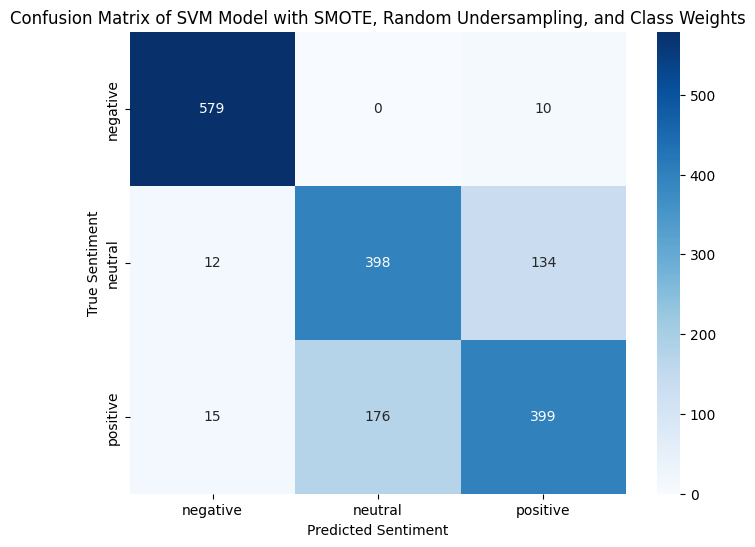

In [48]:
import seaborn as sns

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix of SVM Model with SMOTE, Random Undersampling, and Class Weights')
plt.show()

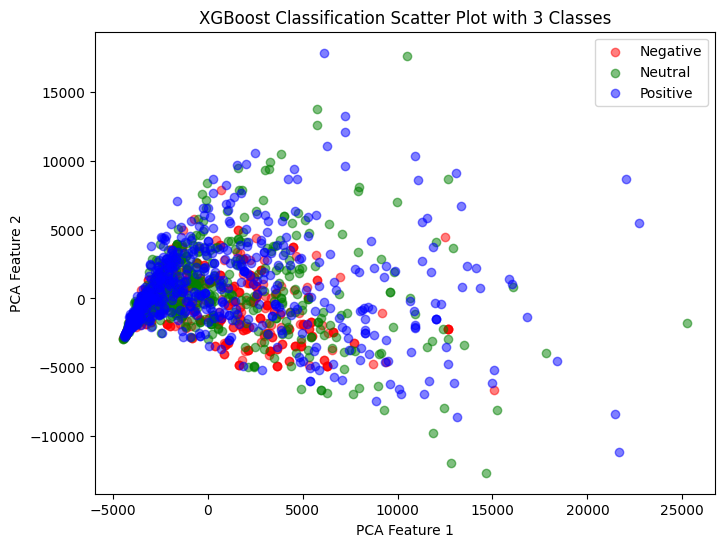

In [73]:
from sklearn.decomposition import PCA

# If X_val has more than 2 features, use PCA to reduce it to 2 dimensions
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val)

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Scatter plot for class 0 (negative)
plt.scatter(X_val_pca[y_pred_xgb == 0, 0], X_val_pca[y_pred_xgb == 0, 1], 
            color='red', label='Negative', alpha=0.5)

# Scatter plot for class 1 (neutral)
plt.scatter(X_val_pca[y_pred_xgb == 1, 0], X_val_pca[y_pred_xgb == 1, 1], 
            color='green', label='Neutral', alpha=0.5)

# Scatter plot for class 2 (positive)
plt.scatter(X_val_pca[y_pred_xgb == 2, 0], X_val_pca[y_pred_xgb == 2, 1], 
            color='blue', label='Positive', alpha=0.5)

# Adding labels and title
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('XGBoost Classification Scatter Plot with 3 Classes')
plt.legend()

plt.show()

In [49]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred_xgb, average='weighted')
recall = recall_score(y_val, y_pred_xgb, average='weighted')
f1 = f1_score(y_val, y_pred_xgb, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.7972
Recall: 0.7986
F1-Score: 0.7972


In [55]:
predict_label = y_val

In [56]:
redicted_df = pd.DataFrame({'predicted': y_pred_xgb}, index=y_val.index)
predict_df = pd.concat([y_val, redicted_df], axis=1)

In [57]:
predict_df

,sentiment,predicted
4205,2,1
1665,1,1
3121,2,2
3126,2,0
3688,0,0
...,...,...
8510,1,1
7445,2,1
2132,0,0
247,1,1


In [59]:
valid_y_val = predict_df.loc[predict_df.index.isin(review_df.index)]
filtered_reviews = review_df.loc[valid_y_val.index]

In [60]:
filtered_reviews

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review,embedding,sentiment
4205,0,11867768,660193827,"The place is a real gem, nestling in the cool ...",Not to be Missed!,Couples,5,The Royal Agricultural Station Angkhang,Phetchabun,P03012884,joy,place real gem nestling cool green upland doi ...,"[[-0.006027937866747379, 0.08820415288209915, ...",positive
1665,0,16868178,893223254,"Nice view, but you need to be be careful when ...",Nice view,Friends getaway,5,Chado Cliff Viewpoint,Phra Nakhon Si Ayutthaya,P03017905,joy,nice view need careful hiking natural trail be...,"[[-0.015819119289517403, 0.2557101249694824, 0...",positive
3121,1,556614,874997345,Doi Mae Salong is a beautiful and interesting ...,Beautiful and peaceful,NONE,5,Doi Mae Salong,Nakhon Sawan,P03016134,joy,doi mae salong beautiful interesting place vis...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
3126,0,6669517,632751727,Located on the way we back to our accommodatio...,temple that next to the road,Couples,3,Chedi Phra Borommasaririkkathat Khao Kho,Nakhon Sawan,P03016132,joy,located way back accommodation look time avail...,"[[-0.006226921919733286, 0.06969726830720901, ...",neutral
3688,1,7659431,613000573,i stayed on koh larn at the castello resort ov...,i love this island so much,Solo travel,5,Thong Lang Beach,Sukhothai,P03025214,joy,stayed koh larn castello resort christmas enjo...,"[[-0.0006162917125038803, 0.013998796232044697...",positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0,8874054,875897422,Chaio por Phawo Shrine is the most popular pra...,Most Respect shine in Mae sot People,NONE,5,Chao Por Phawo Shrine,Nonthaburi,P03016494,joy,chaio por phawo shrine popular pray respect pl...,"[[-0.0091639319434762, 0.1279701143503189, 0.0...",positive
4129,1,1307603,750690836,Took a fast boat for a magical day at Hapla Be...,Blissful,Couples,5,Koh Kho Khao Island,Phetchabun,P03004050,joy,took fast boat magical day hapla beach real ro...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
2132,0,554864,696305303,in the twelfe-year animal cycle the rabbit is ...,the rabbit temple,Couples,5,Wat Phrathat Chae Haeng,Sing Buri,P03013402,joy,twelfeyear animal cycle rabbit one wat phra ch...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
247,0,25571501,929540899,We went on a weekday and was pleased that this...,Best Jodd Fair,Friends getaway,5,Jodd Fairs DanNeramit,Bangkok,P03022261,joy,went weekday pleased jodd fair wasnt packed ma...,"[[-0.0011091228807345033, 0.03485574945807457,...",positive


In [66]:
import sys
import os

parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(parent_directory)
print("Updated sys.path:", sys.path)

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../utils')))

Updated sys.path: ['/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages', '/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/setuptools/_vendor', '/Users/ittichaiboonyarakthunya/Documents/WorkDir/developments/IS_Project_Thailand_Tourism_Recommendation', '/Users/ittichaiboonyarakthunya/Documents/WorkDir/developments/IS_Project_Thailand_Tourism_Recommendation']


In [67]:
from utils.data_preparation import DataPreparation

DP = DataPreparation()
DP.check_nltk_path()


Numpy version: 1.26.4
Pandas version: 2.2.0
True


In [72]:

predictions_df = pd.DataFrame({
    'location_id': filtered_reviews['location_id'],
    'location_name': filtered_reviews['location_name'],
    'review_id': filtered_reviews['review_id'],
    'emotion': filtered_reviews['emotion'],
    'trip_type': filtered_reviews['trip_type'],
    'rating': filtered_reviews['rating'],
    'helpful_voting': filtered_reviews['helpful_votes'],
    'review_text': filtered_reviews['review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': predict_df['sentiment'],  # The actual sentiment labels
    'predicted_sentiment': predict_df['predicted']  # The predicted sentiment labels
})

setiment_lable_mapping = {0: 'negative', 1: 'netural', 2: 'positive'}
predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(setiment_lable_mapping)
predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(setiment_lable_mapping)

predictions_df.head(10)


,location_id,location_name,review_id,emotion,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment
8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,738692369.0,love,NONE,5.0,2.0,One of the least crowded temples but very beau...,positive,positive
14,311043.0,Wat Phra Chetuphon,962482865.0,surprise,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",netural,netural
17,317504.0,Temple Of Dawn (Wat Arun),955989676.0,joy,Solo travel,5.0,15.0,"Known as Temple of Dawn, I went to this temple...",negative,negative
19,317504.0,Temple Of Dawn (Wat Arun),955712588.0,sadness,Family,4.0,0.0,I have to admit that this is a place i have al...,negative,negative
23,456322.0,Wat Umong,936553670.0,joy,Family,5.0,0.0,The visit to this temple was a good pick for u...,netural,netural
26,1368436.0,Wat Rong Khun,962490689.0,joy,Couples,3.0,0.0,Beautiful from afar but up close rather tacky ...,negative,negative
31,7913913.0,Wat Pak Nam,935907604.0,love,Friends getaway,4.0,2.0,Like a lot of Bangkok it’s all where you least...,positive,positive
33,7913913.0,Wat Pak Nam,890055418.0,joy,Solo travel,5.0,0.0,One of the newest Temples in Bangkok and very ...,negative,negative
37,447648.0,Wat Phra Singh,947799000.0,joy,Couples,4.0,0.0,This is a beautiful wat from the outside and h...,netural,positive
41,456623.0,Wat Chaiwatthanaram,946867745.0,joy,Couples,5.0,0.0,Visited with our 'With the locals' guide Piyap...,positive,positive
